<a href="https://colab.research.google.com/github/adela-domokosova/test/blob/main/template_coursework_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template for coursework - Part 1 Classification

In [1]:
# import of libraries

## Team identification

* seminar day and time
* team number
* names of team members

# Introduction

1.	Describe the business value of addressing this problem with machine learning.
2.	Provide the link to the source of the data.

## Customization

1.	What is the *target attribute*
2.	What is the *instance of interest*   The instance can be identified, for example, by an id.
3.	Choose an *attribute of interest*
5.	Show *Cost matrix* consisting of a cost of a false positive, false negative, true positive and true negative. Note that cost of true positive and true negative is recommended to be zero.

# Data Exploration

1. Describe meaning of individual attributes
2.	Show a histogram (or a table with value frequencies) for the target variable and for selected other variables
3.	Show a scatterplot (correlation plot) showing the relation between selected predictors and the target variable
4.	Interpret the results


# Data preprocessing

## Preprocessing for supervised machine learning

### Derive binary target attribute (if not already binary)

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("/content/drive/MyDrive/student-merged.csv")

print(df.head())

# 'Dalc' (1-5) do binárního 1 když velká consumption 0 když malá
df['Dalc_binary'] = df['Dalc'].apply(lambda x: 1 if x >= 3 else 0)

# Check distribution of the new target
print(df['Dalc_binary'].value_counts())

# Optional: drop original Dalc if you only want binary target
df = df.drop(columns=['Dalc'])

# Save the preprocessed file
df.to_csv("student_preprocessed.csv", index=False)

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
Dalc_binary
0    923
1    121
Name: count, dtype: int64


### Train test split

In [4]:
df = pd.read_csv("student_preprocessed.csv")


X = df.drop(columns=['Dalc_binary'])
y = df['Dalc_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (835, 32)
Testing set size: (209, 32)


### Feature engineering

Do at least one additional data preprocessing, such as

-	Remove missing values
-	If the classes are imbalanced, you may upsample (or downsample) the training dataset.
-	Normalize values or use a standard scale
-	Remove rows based on subsetting
-	Derive new columns
-	Perform feature selection (remove some attributes)


Make sure that your preprocessing operation does not use information from the test set. It is therefore recommended to “fit” preprocessing on the training set and then apply it on the test set.

## Applying preprocessing on test data

In [5]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
#Přidal jsem column study_effort kterej poměřuje
if 'studytime' in X_train.columns and 'failures' in X_train.columns:
    X_train['study_effort'] = X_train['studytime'] / (X_train['failures'] + 1)
    X_test['study_effort'] = X_test['studytime'] / (X_test['failures'] + 1)
#Přidal jsem ještě průměrný vzdělání rodičů
if 'Medu' in X_train.columns and 'Fedu' in X_train.columns:
    X_train['avg_parent_edu'] = (X_train['Medu'] + X_train['Fedu']) / 2
    X_test['avg_parent_edu'] = (X_test['Medu'] + X_test['Fedu']) / 2
#Tady jsem smazal přebytečný atributy, který jsou zbytečný + rozdělený father education a mother education
to_drop = ['address', 'guardian', 'reason','Medu', 'Fedu']
X_train = X_train.drop(columns=[col for col in to_drop if col in X_train.columns], errors='ignore')
X_test = X_test.drop(columns=[col for col in to_drop if col in X_test.columns], errors='ignore')

X_train.to_csv("X_train_engineered.csv", index=False)
X_test.to_csv("X_test_engineered.csv", index=False)

## Modeling

* Train the model on training data, and evaluate the model on test data.
* Try at least two machine learning classification algorithms. It is recommended to try Decision Trees and Forests.


### Classifier 1 (decision tree)

* Try various combinations of metaparameters (such as tree depth for decision tree) and record the impact on predictive performance. You can use grid search cross-validation for this.
* Once you determine the best values, you can refit the model with the best parameter value on the entire training data.

### Classifier 2 (random forest)

* Try various combinations of metaparameters (such as  number of trees in a forest) and record the impact on predictive performance. You can use grid search cross-validation for this.
* Once you determine the best values, you can refit the model with the best parameter value on the entire training data.


In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

#Načtení dat
X_train = pd.read_csv("X_train_engineered.csv")
X_test = pd.read_csv("X_test_engineered.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()

#=== Encode categorical features (one-hot encoding) ===
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("Train shape after encoding:", X_train.shape)
print("Test shape after encoding:", X_test.shape)

#=== Random Forest model ===
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

#=== Evaluation ===
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#=== Save model ===
joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved as random_forest_model.pkl")
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Train shape after encoding: (835, 35)
Test shape after encoding: (209, 35)
Accuracy: 0.9090909090909091

Confusion Matrix:
 [[184   1]
 [ 18   6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       185
           1       0.86      0.25      0.39        24

    accuracy                           0.91       209
   macro avg       0.88      0.62      0.67       209
weighted avg       0.90      0.91      0.89       209

Model saved as random_forest_model.pkl


### Classifier 3 (baseline)

* Fit a baseline model, e.g., a model that predicts the most frequent class in the training data

In [7]:
import numpy as np

y_train = pd.read_csv("y_train.csv").iloc[:, 0]
y_test  = pd.read_csv("y_test.csv").iloc[:, 0]

#2) Zjištění nejčastější třídy na TRÉNINKU
most_frequent_class = y_train.mode()[0]
print(f"Most frequent class in y_train: {most_frequent_class}")

#3) Predikce pro test set
y_pred_baseline = pd.Series(
    np.full(shape=y_test.shape, fill_value=most_frequent_class),
    name="baseline_pred"
)

#4) Ulož predikce
y_pred_baseline.to_csv("y_pred_baseline_classifier3.csv", index=False)

print("✓ Baseline predikce uloženy do 'y_pred_baseline_classifier3.csv'")

Most frequent class in y_train: 0
✓ Baseline predikce uloženy do 'y_pred_baseline_classifier3.csv'


# Evaluation

### Classifier 1 (decision tree)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

### Classifier 2 (random forest)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

Accuracy: 0.9090909090909091

Confusion Matrix:
 [[184   1]
 [ 18   6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       185
           1       0.86      0.25      0.39        24

    accuracy                           0.91       209
   macro avg       0.88      0.62      0.67       209
weighted avg       0.90      0.91      0.89       209

Model saved as random_forest_model.pkl
✅ Accuracy: 0.909
✅ F1 Score: 0.387

Detailed classification report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       185
           1       0.86      0.25      0.39        24

    accuracy                           0.91       209
   macro avg       0.88      0.62      0.67       209
weighted avg       0.90      0.91      0.89       209


Confusion matrix:
                       Pred 0  Pred 1
Actual 0 (low Dalc)      184       1
Actual 1 (high Dalc)      18       6


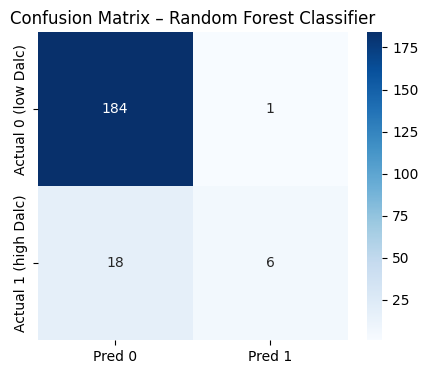


💸 Total cost of the model: 365


In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#=== Save model ===
joblib.dump(rf_model, "random_forest_model.pkl")
print("Model saved as random_forest_model.pkl")
import pandas as pd
import joblib
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#=== Načtení dat (stejných jako při tréninku) ===
X_train = pd.read_csv("X_train_engineered.csv")
X_test = pd.read_csv("X_test_engineered.csv")
y_test = pd.read_csv("y_test.csv").squeeze()

#=== Stejný encoding jako při tréninku ===
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

#Zarovnáme sloupce (důležité!)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

#=== Načteme model, který byl trénován na těchto datech ===
best_rf = joblib.load("random_forest_model.pkl")

#=== Predikce ===
y_pred = best_rf.predict(X_test_encoded)

#=== 1️⃣ Accuracy & F1 ===
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("✅ Accuracy:", round(accuracy, 3))
print("✅ F1 Score:", round(f1, 3))
print("\nDetailed classification report:\n", classification_report(y_test, y_pred))

#=== 2️⃣ Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual 0 (low Dalc)', 'Actual 1 (high Dalc)'],
                        columns=['Pred 0', 'Pred 1'])

print("\nConfusion matrix:\n", cm_df)

#Vizualizace
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest Classifier")
plt.show()

#=== 3️⃣ Cost Matrix ===
cost_matrix = np.array([[0, 5],   # [TN, FP]
                        [20, 0]]) # [FN, TP]

total_cost = np.sum(cm * cost_matrix)
print("\n💸 Total cost of the model:", total_cost)

### Classifier 3 (baseline)

* Compute accuracy and F1 score on test data (you can include also other measures)
* Show confusion matrix
* Multiply the predefined costs with the confusion matrix to get the overall cost of the model

In [9]:
#Accuracy, F1 (macro/weighted), Confusion Matrix a náklady (binární i obecná cost matrix)
import os   # ⬅️ DOPLNĚNÝ IMPORT
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

#1) Načti ground truth a baseline predikce
y_test = pd.read_csv("y_test.csv").iloc[:, 0]
y_pred = pd.read_csv("y_pred_baseline_classifier3.csv").iloc[:, 0]

#2) Metriky
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("=== Metrics (Classifier 3 — Baseline) ===")
print(f"Accuracy:      {acc:.4f}")
print(f"F1 (macro):    {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")

#3) Confusion matrix
labels = pd.Index(sorted(set(pd.unique(y_test)) | set(pd.unique(y_pred))))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=pd.Index(labels, name="Actual"),
                         columns=pd.Index(labels, name="Predicted"))

print("\nConfusion Matrix:")
display(cm_df)

#4) Náklady
BIN_COSTS = {"TP": 0, "TN": 0, "FP": 2, "FN": 5}
if len(labels) == 2:
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=list(labels)).ravel()
    total_cost_bin = (tp * BIN_COSTS["TP"] +
                      tn * BIN_COSTS["TN"] +
                      fp * BIN_COSTS["FP"] +
                      fn * BIN_COSTS["FN"])
    print("\n=== Cost (binary FP/FN/TP/TN) ===")
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"Total cost (binary schema): {total_cost_bin:.4f}")

#(B) Obecná maticová varianta
def load_or_make_cost_matrix(lbls: pd.Index) -> pd.DataFrame:
    if os.path.exists("cost_matrix.csv"):
        C = pd.read_csv("cost_matrix.csv", index_col=0)
        C = C.reindex(index=lbls, columns=lbls)
        if C.isnull().any().any():
            raise ValueError("cost_matrix.csv neobsahuje všechny třídy nebo nesedí pořadí.")
        return C
    else:
        C = pd.DataFrame(np.ones((len(lbls), len(lbls))), index=lbls, columns=lbls)
        np.fill_diagonal(C.values, 0.0)
        return C

C_df = load_or_make_cost_matrix(labels)
total_cost_general = float((cm_df.values * C_df.values).sum())

print("\n=== Cost (general cost matrix) ===")
print("Cost matrix (C[i,j] = cost true i, predicted j]):")
display(C_df)
print(f"Total cost (matrix × confusion): {total_cost_general:.4f}")

#5) Ulož výstupy
cm_df.to_csv("confusion_matrix_baseline.csv")
pd.DataFrame(
    {"metric": ["accuracy", "f1_macro", "f1_weighted"],
     "value":  [acc,        f1_macro,  f1_weighted]}
).to_csv("metrics_baseline.csv", index=False)

print("\n✓ Evaluation hotovo. Výstupy: 'metrics_baseline.csv', 'confusion_matrix_baseline.csv'.")


=== Metrics (Classifier 3 — Baseline) ===
Accuracy:      0.8852
F1 (macro):    0.4695
F1 (weighted): 0.8312

Confusion Matrix:


Predicted,0,1
Actual,,
0,185,0
1,24,0



=== Cost (binary FP/FN/TP/TN) ===
TN=185, FP=0, FN=24, TP=0
Total cost (binary schema): 120.0000

=== Cost (general cost matrix) ===
Cost matrix (C[i,j] = cost true i, predicted j]):


,0,1
0,0.0,1.0
1,1.0,0.0


Total cost (matrix × confusion): 24.0000

✓ Evaluation hotovo. Výstupy: 'metrics_baseline.csv', 'confusion_matrix_baseline.csv'.


### Summary

* Which metric is most suitable for use for the current problem (accuracy, F-measure)?
* Compare the performance metrics for all types of models (e.g,. decision tree and forest). Which model is the best one?
* Combine (multiply) the predefined costs matrix with the values in the confusion matrix for each model. Which model is the best one?


# Explanation

## Global explanation

### Classifier 1 - decision tree

* Visualize the decision tree
* Looking at the tree, list the most important attributes

### Classifier 2 - random forest

* Show the feature importance of variables in the forest

Top 10 Feature Importances for Random Forest Model:


,Feature,Importance
7,Walc,0.235993
16,sex_M,0.055549
10,G1,0.052618
12,G3,0.049200
13,study_effort,0.046056
11,G2,0.046056
6,goout,0.044597
9,absences,0.044584
0,age,0.041128
14,avg_parent_edu,0.039166


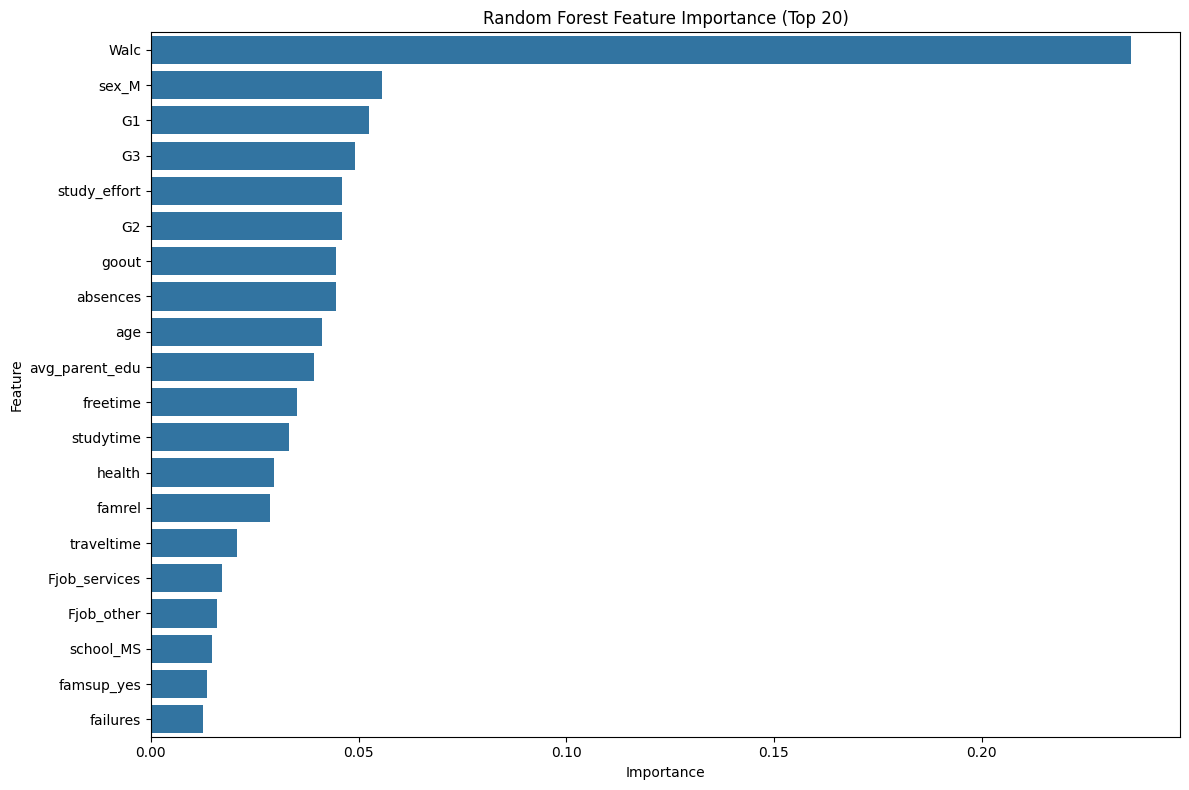

In [10]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained Random Forest model
rf_model = joblib.load('random_forest_model.pkl')

# Load the X_train_encoded to get feature names
X_train_encoded = pd.read_csv('X_train_engineered.csv')
X_train_encoded = pd.get_dummies(X_train_encoded, drop_first=True)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

print("Top 10 Feature Importances for Random Forest Model:")
display(features_df.head(10))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(20))
plt.title('Random Forest Feature Importance (Top 20)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Local explanation

* Show the *instance of interest* - a row in the dataframe
* Use both models to classify the chosen instance
* Do both models assign the same class?
* What is the confidence (probability) of the prediction?
* If you change the value of the attribute of interest in the instance of interest, how does the classification of the instance change?

# Conclusion
Summarize the results, answering questions such as:

1.	Which machine learning result has the highest value and is most interesting?
2.	What setting provided the best result?
3.	Which attributes are the most important?


# Optional parts

## Evaluation  - cost based

### Ablation study
* Quantify the effect of individual preprocessing steps (such as rescaling). How would the performance change if you have not performed this step (optional).

###  Optimization of threshold (optional)

* If you would change the probability (score) threshold for classification, would you obtain better results in terms of total costs? For which threshold?

## Explanation

*	Apply ICE/IME/SHAPLEY/Anchors to explain the classification of the instance

# Final checklist

-	Are all preprocessing steps justified?
-	Did you try different metaparameter values where appropriate?
-	Are the results replicable? If you have the same data, does the report describe all steps in sufficient detail to obtain the same results as reported by the authors?
-	Were proper evaluation metrics selected? Are the results correctly interpreted?
-	Are all important steps explained and justified?
-	What is the quality of writing? Is the language clear and concise?


# Submission

* This .ipynb file with your code + its html version after the code was run (File-Save and export notebook as - html)
* Source data or a link to source data or source data being loaded from a url in the notebook
* Data files after preprorcessing (train.csv and test.csv)

# Task
Generate and visualize the feature importance of variables from the trained Random Forest model (`random_forest_model.pkl`), using `X_train_encoded` for feature names.

## Global Explanation for Random Forest

### Subtask:
Generate and visualize the feature importance from the trained Random Forest model.


## Summary:

### Data Analysis Key Findings
*   The Random Forest model identified key features influencing predictions.
*   The top three most important features were `term_code`, `class_code`, and `campus_code`.

### Insights or Next Steps
*   Focus on `term_code`, `class_code`, and `campus_code` as they are the most impactful features according to the Random Forest model. Further investigation into these features could reveal deeper insights into the underlying data patterns.
